# ARIMAモデル

観測値を直接モデル化する手法について述べる。

In [1]:
# パッケージのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm

%matplotlib inline

## ARモデル: 自己回帰モデル

アイスクリームの販売数データを使ってStatsModelsでARモデルを構築する

2003-01-31    331
2003-02-28    268
2003-03-31    365
2003-04-30    492
2003-05-31    632
Freq: M, dtype: int64


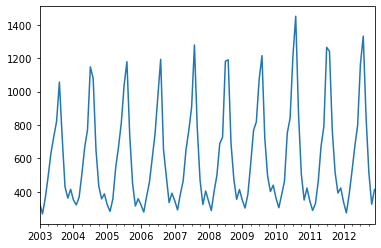

In [2]:
# CSVからデータの読み出し
orig_data = pd.read_csv("./data/icecream.csv", encoding="shift-jis", header=1)
# データの変換
df_ice = orig_data.rename(columns={"年":"year", "月":"month", "アイスクリーム":"expenditure_yen"})

# 月ごとの家庭平均消費額のみを抽出する
# インデックスを2003年1月からの月ごとにする
y = pd.Series(df_ice.expenditure_yen.values, index=pd.date_range("2003-1", periods=len(df_ice), freq="M"))

# 確認
print(y.head())
# 図示
y.plot()

### 定常過程か確認する

- ARモデルは定常過程にしか適用できないので、データが定常過程であるかどうかを調べる必要がある。
    - 前半100時点のデータに対してADF検定を実施して定常かどうかを判断する。

In [4]:
from statsmodels.tsa import stattools

# トレンド項あり(2次まで), 定数項ありの場合
ctt = stattools.adfuller(y[:100], regression="ctt")

# トレンド項あり(1次), 定数項ありの場合
ct = stattools.adfuller(y[:100], regression="ct")

# トレンド項なし、定数項ありの場合
c = stattools.adfuller(y[:100], regression="c")

# トレンド項なし、定数項なしの場合
nc = stattools.adfuller(y[:100], regression="nc")

# 確認
print("ctt: ")
print(ctt)

print("ct: ")
print(ct)

print("c: ")
print(c)

print("nc: ")
print(nc)

ctt: 
(-3.3089558508822234, 0.16922448619685926, 11, 88, {'1%': -4.507929662788786, '5%': -3.9012866601709244, '10%': -3.595623127758734}, 993.4892589484145)
ct: 
(-1.7145601999710802, 0.7444294601457546, 11, 88, {'1%': -4.065513968057382, '5%': -3.4616143302732905, '10%': -3.156971502864388}, 1002.5847722693204)
c: 
(-0.6539247687694234, 0.8583259363632656, 11, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 1003.5884336394024)
nc: 
(1.631094917975906, 0.9751761218376865, 11, 88, {'1%': -2.5916151807851238, '5%': -1.944440985689801, '10%': -1.614115063626972}, 1002.1878264328066)


In [5]:
# p値(2番目の要素)のみを抽出
print(ctt[1])
print(ct[1])
print(c[1])
print(nc[1])

0.16922448619685926
0.7444294601457546
0.8583259363632656
0.9751761218376865


- p値はいずれも高く、帰無仮説(=単位根過程である)という仮説を棄却できない。(=単位根過程であるので定常ではない)
    - 1次階差をとって定常過程に変換する

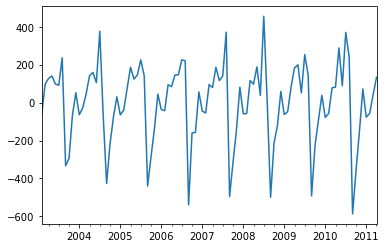

In [6]:
# 1次階差系列
y_diff = y.diff()[:100].dropna()
y_diff.plot()

In [11]:
# 1次階差系列で単位根検定する
# トレンド項あり(2次まで), 定数項ありの場合
ctt = stattools.adfuller(y_diff, regression="ctt")

# トレンド項あり(1次), 定数項ありの場合
ct = stattools.adfuller(y_diff, regression="ct")

# トレンド項なし、定数項ありの場合
c = stattools.adfuller(y_diff, regression="c")

# トレンド項なし、定数項なしの場合
nc = stattools.adfuller(y_diff, regression="nc")

# 確認
print("ctt: ")
print(ctt)

print("ct: ")
print(ct)

print("c: ")
print(c)

print("nc: ")
print(nc)

ctt: 
(-20.49413879057403, 0.0, 10, 88, {'1%': -4.507929662788786, '5%': -3.9012866601709244, '10%': -3.595623127758734}, 994.1683226214956)
ct: 
(-20.51282538674092, 0.0, 10, 88, {'1%': -4.065513968057382, '5%': -3.4616143302732905, '10%': -3.156971502864388}, 992.6851493902554)
c: 
(-20.63599924555566, 0.0, 10, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 990.9785010415185)
nc: 
(-20.33772445910237, 0.0, 10, 88, {'1%': -2.5916151807851238, '5%': -1.944440985689801, '10%': -1.614115063626972}, 991.6754513068397)


すべてのパターンでp値は0.05を切っており、定常過程であることがわかった。  
1次階差系列が定常過程であることを確認できたいので、1次階差系列をつかって　ARモデルを構築する。

In [12]:
# ARモデル
from statsmodels.tsa import ar_model

model = ar_model.AR(y_diff)

c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning

In [13]:
# AICをもちいてモデル選択
for i in range(20):
    model = ar_model.AR(y_diff)
    results = model.fit(maxlag=i+1)
    print('lag = ', i+1, 'aic:', results.aic)

lag =  1 aic: 10.623349835083612
lag =  2 aic: 10.605625887136187
lag =  3 aic: 10.631794365499909
lag =  4 aic: 10.653968819566964
lag =  5 aic: 10.639020494849978
lag =  6 aic: 10.497805079154896
lag =  7 aic: 10.50164556083358
lag =  8 aic: 10.347418412668333
lag =  9 aic: 10.145773136713263
lag =  10 aic: 9.547393191591683
lag =  11 aic: 8.688494352586085
lag =  12 aic: 8.726168706454176
lag =  13 aic: 8.749080458269447
lag =  14 aic: 8.787463716774608
lag =  15 aic: 8.822181088075927
lag =  16 aic: 8.861619646480914
lag =  17 aic: 8.900710667979508
lag =  18 aic: 8.712739176754758
lag =  19 aic: 8.74636247304398
lag =  20 aic: 8.766450545272324


- ラグ11で最もAICが低いため、11時点前までのデータとの相関が強いことがわかる。
    - AR(11)モデルを構築する

In [14]:
# モデルのあてはめ
model = ar_model.AR(y_diff)
results11 = model.fit(maxlag=12, ic="aic")
# AICを元に選択されたラグの次数は11のはず
results11.k_ar

11

<BarContainer object of 88 artists>

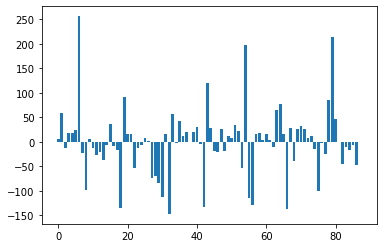

In [15]:
# あてはめのよさを残差を見て確認する
# 残差
res11 = results11.resid

# 残差の出力
plt.bar(range(len(res11)), res11)

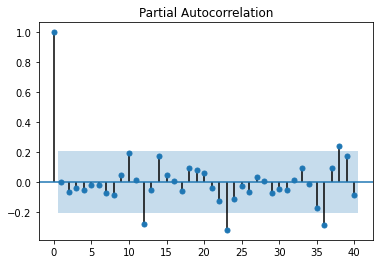

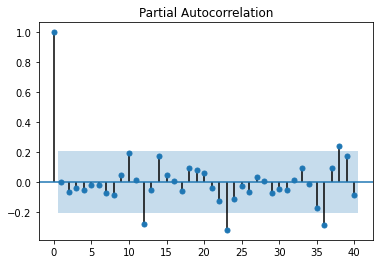

In [16]:
# AR(11)モデルの残差の偏自己相関を確認する

from statsmodels.graphics import tsaplots

tsaplots.plot_pacf(res11, lags=40)

偏自己相関をみるとまだ相関は有意に残っているので、AR(11)が1次階差系列にある12か月の循環成分を十分に表現できていないことがわかる。

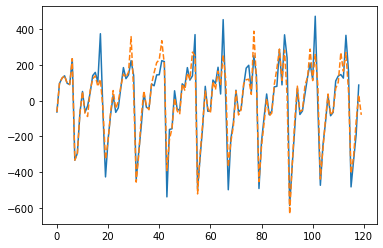

In [17]:
# 原系列の表示
plt.plot(y.diff().dropna().values, label="observtion")

# 1時点から11時点の原系列、モデルのあてはめに使用したデータ、
# AR(11)モデルによる推定値を連結した結果の表示
plt.plot(np.hstack([y_diff[:11],
                    results11.fittedvalues,
                    results11.predict(98-11, 107, dynamic=True)]),
         '--', label="forecast")

## MAモデル: 移動平均モデル

ARモデルとは異なり、ある一定の値の周りをランダムに動くモデル。  
ホワイトノイズの線形和となる。

## ARMAモデル: 自己回帰移動平均モデル(ARMA model: autoregressive moving agerage model)

ARモデルとMAモデルの両者の性質を含んだモデルであり、ARモデルに残差の移動平均を加えたモデル。

In [27]:
# CSVからデータの読み出し
orig_data = pd.read_csv("./data/icecream.csv", encoding="shift-jis", header=1)
# データの変換
df_ice = orig_data.rename(columns={"年":"year", "月":"month", "アイスクリーム":"expenditure_yen"})

# 月ごとの家庭平均消費額のみを抽出する
# インデックスを2003年1月からの月ごとにする
y = pd.Series(df_ice.expenditure_yen.values, index=pd.date_range("2003-1", periods=len(df_ice), freq="M"))

# 1次階差系列
y_diff = y.diff()[:100].dropna()

In [32]:
from statsmodels.tsa import stattools

# 次数選択の指標にAICとBICを選択
info_criteria = stattools.arma_order_select_ic(y_diff, ic=['aic', 'bic'])

# AICとBICが最小になる次数をそれぞれ表示
print(info_criteria.aic_min_order)
print(info_criteria.bic_min_order)

c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


(2, 2)
(2, 2)


c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMAモデルのあてはめにはStatsModelsのarima_mode.ARMA関数を用いる

In [33]:
from statsmodels.tsa.arima_model import ARMA

# p=2, q=2のARMAモデルのインスタンスを生成
model = ARMA(y_diff, (2,2))

# y_diffに対してモデルをあてはめる
results = model.fit()

<BarContainer object of 99 artists>

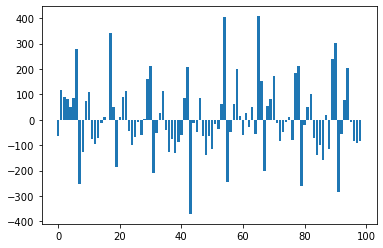

In [34]:
# 残差の抽出
res = results.resid

# 残差の出力
plt.bar(range(len(res)), res)

c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


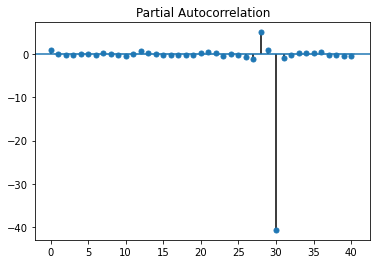

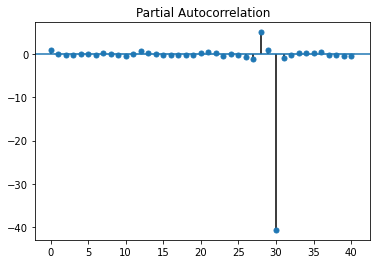

In [35]:
# 残差の偏自己相関の確認
from statsmodels.graphics import tsaplots

tsaplots.plot_pacf(res, lags=40)

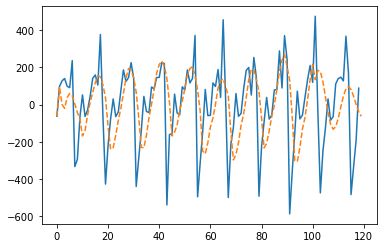

In [37]:
# 1次の階差系列の表示
plt.plot(y.diff().dropna().values, label="observation")
# ARMA(2, 2)による推定値の表示
plt.plot(np.hstack([y_diff[:2],
                   results.fittedvalues,
                   results.predict(99-2, 115, dynamic=True)]),
        '--', label="forecast")

## ARIMAMモデル: 自己回帰和分移動平均モデル(ARIMA, autoregressive integrated moving average model)

- ARMAモデルを非定常過程に対応させたものである。
- 弱定常過程であり、ARIMAモデルを適用するかどうかはトレンドなどの平均値揺動が存在するかどうかによる。
    - 階差系列をつくって揺動が解消されているかどうかを検討し、dの値を決定する。
        - 平均値揺動とは時系列データの平均値が時刻とともに変化することを表す

月ごとの旅客機の乗客数データを使用してモデルを構築する。  

In [38]:
import io
import requests
import statsmodels.api as sm

# 月ごとの旅客機の乗客数データ
url = "http://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode("utf-8")))

df_content = content.copy()

In [43]:
df_content.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [42]:
df_content['Month'] = pd.to_datetime(df_content['Month'], infer_datetime_format=True)
df_content.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


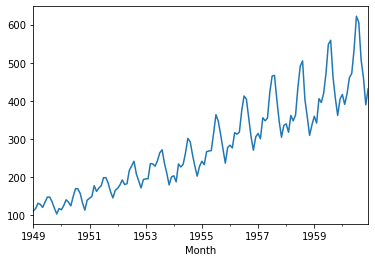

In [45]:
y = pd.Series(df_content["#Passengers"].values, index=df_content["Month"])
y = y.astype("f")
y.plot()

- データは全部で144時点
    - 前半: 120時点をモデル構築に使用: y120
    - 後半: 24時点を長期予測の確認のために使用する。

- 階差を取らずにモデルを構築し、長期予測の際にトレンドがとらえられているかどうかを確認する。

c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<BarContainer object of 119 artists>

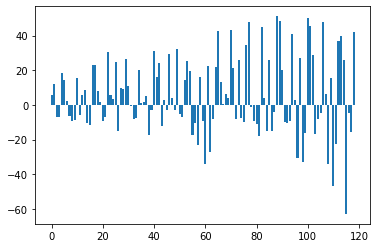

In [47]:
# 階差を取らないパターン(ARIMA)

from statsmodels.tsa.arima_model import ARIMA

# 対象データ
y120 = y[:120]
# 階差を取らないモデル(p,d,q)=(3,0,2)
model_d0 = ARIMA(y120, (3,0,2))
# 学習
results_d0 = model_d0.fit()
# 残差
res_d0 = results_d0.resid
# 残差の出力
plt.bar(range(len(res_d0[1:])), res_d0[1:])

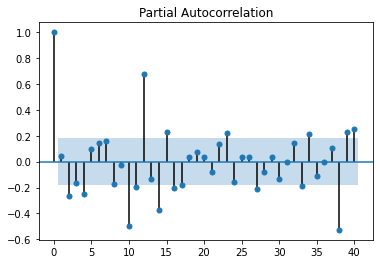

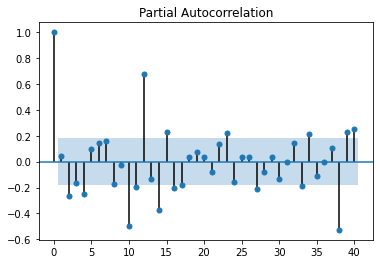

In [48]:
# 残差の偏自己相関
from statsmodels.graphics import tsaplots

tsaplots.plot_pacf(res_d0[1:], lags=40)

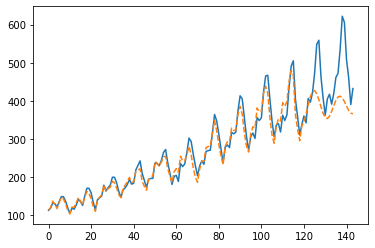

In [49]:
# 原系列との比較
plt.plot(y.values, label="observtion")

plt.plot(results_d0.predict(1, len(y)).values, '--', label="forecast")

残差を取らない場合、
- 偏自己相関が残っているので循環成分をモデルが表現しきれていない
- 120時点以降の予測ができていない

ARIMA(4,1,1)モデルを構築して、ARIMA(3,0,2)モデルと同様に残差の確認から行う。 

In [75]:
from statsmodels.tsa.arima_model import ARIMA


# 階差1をとったモデル(p,d,q)=(4,1,1)
model_d1 = ARIMA(y120, (4,1,1))
# 学習
results_d1 = model_d1.fit()
# 残差
res_d1 = results_d1.resid

c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


MissingDataError: exog contains inf or nans

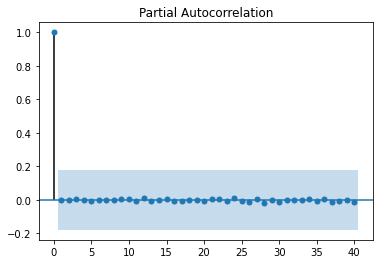

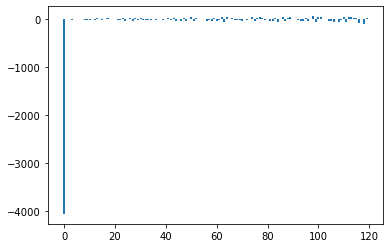

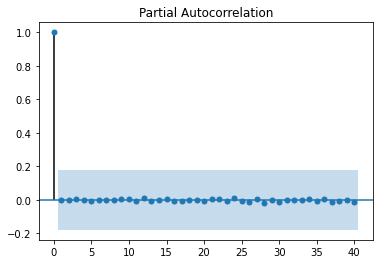

In [76]:
# 残差の出力
plt.bar(range(len(res_d1)), res_d1)
# 偏自己相関を確認する
tsaplots.plot_pacf(res_d1, lags=40)

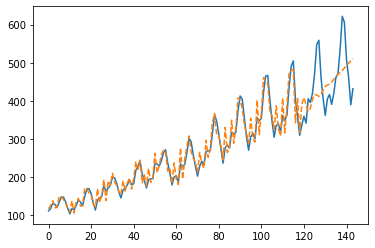

In [77]:
# 原系列の表示
plt.plot(y.values, label="observation")
plt.plot(results_d1.predict(1, len(y)).values, '--', label="forecast")